## Text Analytics


#### Student Name & PG ID: 

1. Unnati Khinvasara  - 12120097 

2. Kenny Devarapalli - 12120062 

3. Siddharth Maheshwari - 12120058 

4. Raktim Prakash Srivastava - 12120044 

5. Anjali Rathore - 12120089 



Github Link : https://github.com/Raktim-Srivastava/Text-Analytics-Group-Project

In [2]:
import time
start = time.time()

# Initializing all libraries
import pandas as pd
import numpy as np

# For manipulating text data
import re
import nltk
import string 
import contractions
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer  
lemma = WordNetLemmatizer()
from gensim.parsing.preprocessing import strip_punctuation, strip_tags, strip_numeric

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For language conversion
from langdetect import detect
from autocorrect import Speller
spell = Speller(lang='en')
from deep_translator import GoogleTranslator

# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf

# NLTK Stop words extended
stopwords.extend(['from', 'subject', 're', 'edu', 'use'])
stopwords.extend(["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'])

In [3]:
# Initializing custom functions

def language_translater(text):
    translated = GoogleTranslator(source=detect(text), target='en').translate(text)
    return translated

def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(str(i), j + " ")
    return text

def textClean(text):
    cleantext = " ".join([lemma.lemmatize(word.lower()) for word in strip_numeric(strip_punctuation(text)).split()])
    return cleantext

def tokenize_only(text):
    # Tokenizing each sentence and then word
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.lower() not in stopwords]
    
    filtered_tokens = []
    
    # Filtering out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

def tokenize_and_stem(text):
    filtered_tokens = tokenize_only(text)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

from wordcloud import WordCloud
def create_word_cloud(final_data, title):
    wordcloud = WordCloud(width=1600, height=800, max_font_size=200, stopwords = stopwords,
                          background_color='white').generate(final_data)
    
    # plt the image generated by WordCloud class
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title+"\n", fontsize = 16)
    plt.show()
    
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# define unit func to process one doc
from nltk import sent_tokenize, word_tokenize
def vader_unit_func(doc0,column_name):
    sents_list0 = sent_tokenize(doc0)
    vs_doc0 = []
    sent_ind = []
    for i in range(len(sents_list0)):
        vs_sent0 = analyzer.polarity_scores(sents_list0[i])
        vs_doc0.append(vs_sent0)
        sent_ind.append(i)
        
    # obtain output as DF    
    doc0_df = pd.DataFrame(vs_doc0)
    doc0_df.columns = [x+column_name for x in doc0_df.columns]
    doc0_df.insert(0, 'sent_index', sent_ind)  # insert sent index
    doc0_df.insert(doc0_df.shape[1], 'sentence', sents_list0)
    return(doc0_df)

# define wrapper func
def vader_wrap_func(corpus0,column_name):
    
    # use ifinstance() to check & convert input to DF
    if isinstance(corpus0, list):
        corpus0 = pd.DataFrame({'text':corpus0})
    
    # define empty DF to concat unit func output to
    vs_df = pd.DataFrame()    
    
    # apply unit-func to each doc & loop over all docs
    for i1 in range(len(corpus0)):
        doc0 = str(corpus0.iloc[i1])
        vs_doc_df = vader_unit_func(doc0,column_name)  # applying unit-func
        vs_doc_df.insert(0, 'doc_index', i1)  # inserting doc index
        vs_df = pd.concat([vs_df, vs_doc_df], axis=0)
        
    return(vs_df)

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):   
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'].sort_values()
    return(vif)

### 0. Understanding the Business Problem
Uber Inc in the US wants to know:

- the major complaints premium users have about their cab services,
- how these impact service ratings.

We as (technical) consultants to Uber. have to:  
- [a] analyze text reviews of Uber cabs’ US services,  
- [b] relate whether and which different features of these reviews impact overall ratings  
- [c] pinpoint possible areas of improvement.

In [4]:
# Reading the data
df = pd.read_csv("https://raw.githubusercontent.com/Kenrich005/Uber_reviews_textanalytics/main/uber_reviews_itune.csv",
                 encoding='cp1252')
# df1 = pd.read_csv(r"G:\ISB AMPBA\9. Text Analytics\Assignment\uber_reviews_cleaned.csv")
df.head()

,Author_Name,Title,Author_URL,App_Version,Rating,Review,Date
0,#NEVERUBER,Dishonest and Disgusting,https://itunes.apple.com/us/reviews/id663331949,3.434.10005,1,"For half an hour, we tried EVERY UBER SERVICE ...",29-12-2020 01:14
1,$$Heaven,Free offer,https://itunes.apple.com/us/reviews/id810421958,3.434.10005,2,If I’m not eligible for the offer Stop floodin...,01-01-2021 23:17
2,.Disappointed....,Inaccurate,https://itunes.apple.com/us/reviews/id49598333,3.439.10000,2,Consistently inaccurate Uber Eats ETA and the ...,15-01-2021 23:38
3,.i. andrea,bad,https://itunes.apple.com/us/reviews/id689880334,3.434.10005,1,i had my rides canceled back to back. they the...,08-12-2020 01:01
4,-:deka:-,Double charged me for an order,https://itunes.apple.com/us/reviews/id124963835,3.434.10005,1,Two of the same orders was added by accident. ...,15-12-2020 04:02


## 1. Pre-processing: 
- Examine the dataset. 
- ID the columns of interest. 
- Drop special characters, html junk etc. 
- Perform any other preprocessing and text-cleaning activity you think fits this context.

Columns of interest:  
1. Title - Brief summary about the review
2. Rating - Label for supervised learning
3. Review - To extract the sentiment of the complaint
4. Date - Extracting weekday or weekend may give better insight on nature of review

#### Removing redundant columns

In [5]:
df1 = df.drop(['Author_Name','Author_URL','App_Version'],axis=1)
df1.head()

,Title,Rating,Review,Date
0,Dishonest and Disgusting,1,"For half an hour, we tried EVERY UBER SERVICE ...",29-12-2020 01:14
1,Free offer,2,If I’m not eligible for the offer Stop floodin...,01-01-2021 23:17
2,Inaccurate,2,Consistently inaccurate Uber Eats ETA and the ...,15-01-2021 23:38
3,bad,1,i had my rides canceled back to back. they the...,08-12-2020 01:01
4,Double charged me for an order,1,Two of the same orders was added by accident. ...,15-12-2020 04:02


#### Translating Reviews from other languages to english
We found that there were several reviews in other languages  
Our first priority will be to translate that to English

In [6]:
df1['Language'] = df1.Review.apply(lambda text: detect(text))

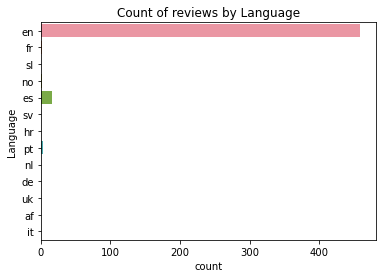

In [7]:
# Plotting countplot for language
fig = plt.figure()
sns.countplot(data = df1, y = 'Language')
plt.title("Count of reviews by Language");  

In [8]:
%%time
df1.Review = df1.Review.apply(lambda text: language_translater(text))
df1.Title = df1.Title.apply(lambda text: language_translater(text))

Wall time: 1min 19s


#### Replacing emoticon with its respective meaning
Several Reviews (and Titles) had emoticons as part of it.  
We need to replace those emoticons with their intended meaning so as to not lose valuable sentiment  
To do so, we have scraped emoticon description data and utilized it below to replace the emoticons with the same 

In [9]:
df_emojis=pd.read_csv("https://raw.githubusercontent.com/Kenrich005/Uber_reviews_textanalytics/main/emoji_description.csv")
df_emojis['Code']=df_emojis['Code'].str.replace('+','+000')
df_emojis.head()

C:\Users\SIDDHA~1\AppData\Local\Temp/ipykernel_7944/4054822596.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_emojis['Code']=df_emojis['Code'].str.replace('+','+000')


,Code,CLDR Short Name
0,<U+0001F600>,grinning face
1,<U+0001F603>,grinning face with big eyes
2,<U+0001F604>,grinning face with smiling eyes
3,<U+0001F601>,beaming face with smiling eyes
4,<U+0001F606>,grinning squinting face


In [10]:
# Making two lists, 1. emoji code, 2. emoji meaning
to_replace = df_emojis.Code.tolist()
replace_with = df_emojis['CLDR Short Name'].tolist()

# Using zip() to convert lists to dictionary
res = dict(zip(to_replace, replace_with))

print("Before emoticon replacement: \n",df1.Review[1])

Before emoticon replacement: 
 If I’m not eligible for the offer Stop flooding my email with this false information <U+0001F621><U+0001F621><U+0001F621>


In [11]:
df1.Review = df1.Review.apply(lambda text: replace_all(text, res))
df1.Title = df1.Title.apply(lambda text: replace_all(text, res))

print("After emoticon replacement: \n",df1.Review[1])

After emoticon replacement: 
 If I’m not eligible for the offer Stop flooding my email with this false information pouting face pouting face pouting face 


#### Removing string that cannot be emoji translated
Wherever emoticons or their like are not able to be translated, (such as arabic letters), we choose to remove them from the string

In [12]:
df1.Review = df1.Review.str.split('<').str[0]
df1.Title = df1.Title.str.split('<').str[0]
df1.shape

(490, 5)

In [13]:
print(df1.Review[149])

#### Dropping null values
One review just had words in arabic, which our model does not incorporate.   
Hence we are dropping it from our analysis.

In [14]:
df1['Review'].replace('', np.nan, inplace=True)
df1['Title'].replace('', np.nan, inplace=True)
df1.dropna(subset=['Review'], inplace=True)
df1 = df1.reset_index(drop=True)
df1.shape

(489, 5)

## 2. Basic text and sentiment analysis

In [15]:
print(df1.Review[1])

If I’m not eligible for the offer Stop flooding my email with this false information pouting face pouting face pouting face 


#### Replacing contraction with their expanded forms
When punctuation is removed, it causes discrepancy among contracted words such as I'm  
We will convert all such words to their expanded form to remove that discrepancy

In [16]:
df1['Review'] = df1.Review.apply(lambda text: contractions.fix(text))
print(df1.Review[1])

If I am not eligible for the offer Stop flooding my email with this false information pouting face pouting face pouting face 


#### Cleaning Text  
We are cleaning the review to remove any alphanumeric values, punctuation, and then lemmatize that word  
This will help in tokenizing later for creating well defined uni-grams and bi-grams

In [17]:
df1['Clean_Review'] = df1.Review.apply(lambda text: textClean(text))
print(df1.Clean_Review[1])

if i am not eligible for the offer stop flooding my email with this false information pouting face pouting face pouting face


#### Tokenizing and Visualizing the Reviews
We want to see what are the Review mostly about  
A wordcloud helps visualize the same better

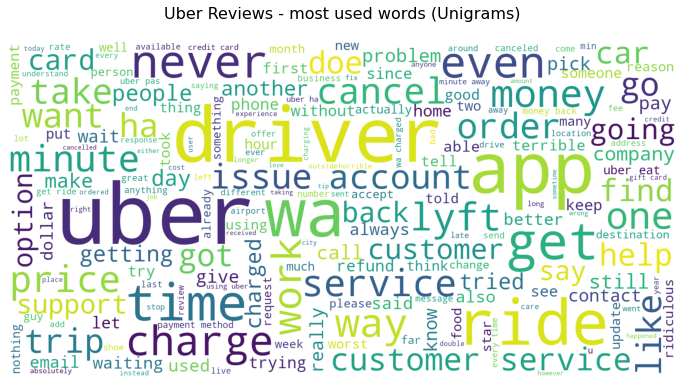

In [18]:
tokenized_text = []
for i in range(len(df1)):
    tokenized_text.extend(tokenize_only(df1.Clean_Review[i]))

create_word_cloud(' '.join(tokenized_text),"Uber Reviews - most used words (Unigrams)")

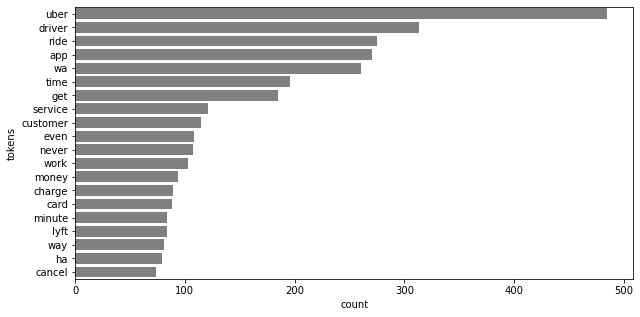

In [19]:
# Barplot of top 20 used words in all the Reviews 
df_tokens = pd.DataFrame(tokenized_text).value_counts().rename_axis('tokens').reset_index(name='count')

plt.figure(figsize=(10,5))
sns.barplot(data=df_tokens.head(20), y='tokens',x='count', color='grey');

## 3. Feature Construction and Extraction
Here, we create features that may aid in better understanding of the Ratings
- Features based on Date, such as IsWeekend, morning, evening, night
- Custom lexicon based on unigrams and bigrams
- Sentiment score based on Vader sentiment

#### Extracting info from Date column

In [20]:
# Converting Date into datetime format
df1['Date'] =  pd.to_datetime(df1['Date'], format='%d-%m-%Y %H:%M')

# Splitting date into multiple parts of day
df1['Isweekend'] = np.where(df1.Date.dt.dayofweek>4,1,0)

timeofday = [0,4,11,19,24]
partofday = ['Late Night','Morning','Noon and Eve','Night']
df1['Day_part'] = pd.cut(df1.Date.dt.hour, bins=timeofday, labels=partofday, include_lowest=True)

df1.head()

,Title,Rating,Review,Date,Language,Clean_Review,Isweekend,Day_part
0,Dishonest and Disgusting,1,"For half an hour, we tried EVERY UBER SERVICE ...",2020-12-29 01:14:00,en,for half an hour we tried every uber service t...,0,Late Night
1,Free offer,2,If I am not eligible for the offer Stop floodi...,2021-01-01 23:17:00,en,if i am not eligible for the offer stop floodi...,0,Night
2,Inaccurate,2,Consistently inaccurate Uber Eats ETA and the ...,2021-01-15 23:38:00,en,consistently inaccurate uber eats eta and the ...,0,Night
3,sea,1,i had my rides canceled back to back. they the...,2020-12-08 01:01:00,en,i had my ride canceled back to back they then ...,0,Late Night
4,Double charged me for an order,1,Two of the same orders was added by accident. ...,2020-12-15 04:02:00,en,two of the same order wa added by accident the...,0,Late Night


In [21]:
# Converting Day_part of dummy variables
df1 = pd.get_dummies(df1, columns=['Day_part'],prefix='', prefix_sep='',drop_first=True)
df1.head()

,Title,Rating,Review,Date,Language,Clean_Review,Isweekend,Morning,Noon and Eve,Night
0,Dishonest and Disgusting,1,"For half an hour, we tried EVERY UBER SERVICE ...",2020-12-29 01:14:00,en,for half an hour we tried every uber service t...,0,0,0,0
1,Free offer,2,If I am not eligible for the offer Stop floodi...,2021-01-01 23:17:00,en,if i am not eligible for the offer stop floodi...,0,0,0,1
2,Inaccurate,2,Consistently inaccurate Uber Eats ETA and the ...,2021-01-15 23:38:00,en,consistently inaccurate uber eats eta and the ...,0,0,0,1
3,sea,1,i had my rides canceled back to back. they the...,2020-12-08 01:01:00,en,i had my ride canceled back to back they then ...,0,0,0,0
4,Double charged me for an order,1,Two of the same orders was added by accident. ...,2020-12-15 04:02:00,en,two of the same order wa added by accident the...,0,0,0,0


#### Building custom lexicon based on unigrams and bigrams

In [22]:
# Unigram
count_vectorizer = CountVectorizer(max_df = 0.9,
                                  max_features=50,
                                  stop_words=stopwords,
                                  tokenizer=tokenize_only,
                                  strip_accents = 'unicode',
                                  ngram_range=(1,1),
                                 )

count_matrix = count_vectorizer.fit_transform(df1.Clean_Review)    
count_tokens = count_vectorizer.get_feature_names()

print(count_matrix.shape)  # Print the dimensions of the matrix

df_unigrams = pd.DataFrame(data = count_matrix.toarray(),columns = count_tokens)
df_unigrams.head()

(489, 50)


,account,app,away,back,cancel,car,card,charge,charged,customer,...,time,trip,uber,used,using,wa,wait,want,way,work
0,0,0,1,0,0,1,0,0,0,0,...,1,1,2,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,1,0,4,0,0,1,0,1,0,...,0,0,1,0,0,1,0,1,0,0
4,0,0,0,0,0,0,0,1,0,2,...,0,0,4,0,1,2,0,0,0,0


In [23]:
df_unigrams.columns

Index(['account', 'app', 'away', 'back', 'cancel', 'car', 'card', 'charge',
       'charged', 'customer', 'day', 'doe', 'driver', 'even', 'every', 'find',
       'get', 'getting', 'go', 'going', 'got', 'ha', 'help', 'issue', 'like',
       'lyft', 'minute', 'money', 'never', 'one', 'option', 'order', 'payment',
       'people', 'price', 'ride', 'say', 'service', 'support', 'take', 'time',
       'trip', 'uber', 'used', 'using', 'wa', 'wait', 'want', 'way', 'work'],
      dtype='object')

In [24]:
# Bi-gram
count_vectorizer = CountVectorizer(max_df = 0.9,
                                  max_features=50,
                                  stop_words=stopwords,
                                  tokenizer=tokenize_only,
                                  strip_accents = 'unicode',
                                  ngram_range=(2,2),
                                 )

count_matrix = count_vectorizer.fit_transform(df1.Clean_Review)    
count_tokens = count_vectorizer.get_feature_names()

print(count_matrix.shape)  # Print the dimensions of the matrix

df_bigrams = pd.DataFrame(data = count_matrix.toarray(),columns = count_tokens)
df_bigrams.columns

(489, 50)


Index(['bank account', 'cancel trip', 'canceled ride', 'cancellation fee',
       'car available', 'credit card', 'customer service', 'customer support',
       'driver cancel', 'driver wa', 'even though', 'every time',
       'face pouting', 'family profile', 'feel like', 'get ride', 'get work',
       'gift card', 'late work', 'min away', 'minute away', 'money back',
       'multiple time', 'payment method', 'phone number', 'pouting face',
       'request ride', 'ride home', 'ride uber', 'schedule ride',
       'scheduled ride', 'several time', 'trip wa', 'trying get', 'uber app',
       'uber cash', 'uber driver', 'uber eats', 'uber get', 'uber ha',
       'uber pas', 'uber wa', 'uber year', 'used uber', 'using app',
       'using uber', 'wa charged', 'wait time', 'waste time', 'wearing mask'],
      dtype='object')

#### Selecting Custom Lexicon

The above tokens are those that have occured more frequently  
From these we select those tokens that we hope help in the explainability of Uber services and its pertaining rating

In [25]:
reqd_tokens = ['account','app','card','charge','customer service','driver','payment',
               'credit card','uber cash','bank account','lyft']

In [26]:
df_combined = pd.concat([df_unigrams,df_bigrams],axis=1)
df_combined = df_combined[reqd_tokens]
df_combined.head()

,account,app,card,charge,customer service,driver,payment,credit card,uber cash,bank account,lyft
0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,0
4,0,0,0,1,1,0,0,0,0,0,0


As 'cancel' is part of 'canceled ride' and 'cancellation fee', we want to create a new feature that identifies if the string 'cancel' is part of the 'Review'

In [27]:
df_combined['cancel'] = np.where(df1.Clean_Review.str.contains('cancel'),1,0)

#### Adding the custom lexicon count to the original data

In [28]:
# Merging the remaining columns to this output
df_clean = pd.concat([df1, df_combined],axis=1)
df_clean.head()

,Title,Rating,Review,Date,Language,Clean_Review,Isweekend,Morning,Noon and Eve,Night,...,card,charge,customer service,driver,payment,credit card,uber cash,bank account,lyft,cancel
0,Dishonest and Disgusting,1,"For half an hour, we tried EVERY UBER SERVICE ...",2020-12-29 01:14:00,en,for half an hour we tried every uber service t...,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,Free offer,2,If I am not eligible for the offer Stop floodi...,2021-01-01 23:17:00,en,if i am not eligible for the offer stop floodi...,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Inaccurate,2,Consistently inaccurate Uber Eats ETA and the ...,2021-01-15 23:38:00,en,consistently inaccurate uber eats eta and the ...,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,sea,1,i had my rides canceled back to back. they the...,2020-12-08 01:01:00,en,i had my ride canceled back to back they then ...,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,Double charged me for an order,1,Two of the same orders was added by accident. ...,2020-12-15 04:02:00,en,two of the same order wa added by accident the...,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


#### Calculating Sentiment Scores using Vader

In [29]:
# Vader Sentiment scores
title_sentiment = vader_wrap_func(df1.Title,'_title').groupby('doc_index').sum()
review_sentiment = vader_wrap_func(df1.Review,'_review').groupby('doc_index').sum()
df_clean = pd.concat([df_clean,review_sentiment,title_sentiment],axis=1)
print(df_clean.shape)
df_clean.head()

(489, 32)


,Title,Rating,Review,Date,Language,Clean_Review,Isweekend,Morning,Noon and Eve,Night,...,sent_index,neg_review,neu_review,pos_review,compound_review,sent_index,neg_title,neu_title,pos_title,compound_title
0,Dishonest and Disgusting,1,"For half an hour, we tried EVERY UBER SERVICE ...",2020-12-29 01:14:00,en,for half an hour we tried every uber service t...,0,0,0,0,...,3,0.000,2.876,0.124,0.1406,0,0.877,0.123,0.000,-0.7964
1,Free offer,2,If I am not eligible for the offer Stop floodi...,2021-01-01 23:17:00,en,if i am not eligible for the offer stop floodi...,0,0,0,1,...,0,0.095,0.905,0.000,-0.2960,0,0.000,0.233,0.767,0.5106
2,Inaccurate,2,Consistently inaccurate Uber Eats ETA and the ...,2021-01-15 23:38:00,en,consistently inaccurate uber eats eta and the ...,0,0,0,1,...,0,0.179,0.821,0.000,-0.3400,0,0.000,1.000,0.000,0.0000
3,sea,1,i had my rides canceled back to back. they the...,2020-12-08 01:01:00,en,i had my ride canceled back to back they then ...,0,0,0,0,...,10,1.167,3.604,0.229,-0.1617,0,0.000,1.000,0.000,0.0000
4,Double charged me for an order,1,Two of the same orders was added by accident. ...,2020-12-15 04:02:00,en,two of the same order wa added by accident the...,0,0,0,0,...,21,0.905,5.617,0.478,-0.4906,0,0.265,0.735,0.000,-0.2023


In [30]:
df_clean.columns

Index(['Title', 'Rating', 'Review', 'Date', 'Language', 'Clean_Review',
       'Isweekend', 'Morning', 'Noon and Eve', 'Night', 'account', 'app',
       'card', 'charge', 'customer service', 'driver', 'payment',
       'credit card', 'uber cash', 'bank account', 'lyft', 'cancel',
       'sent_index', 'neg_review', 'neu_review', 'pos_review',
       'compound_review', 'sent_index', 'neg_title', 'neu_title', 'pos_title',
       'compound_title'],
      dtype='object')

In [31]:
# To avoid multicollinearity between title and Review columns, we will add the compound scores
df_clean['sentiment_score'] = df_clean.compound_review + df_clean.compound_title

In [32]:
# Dropping redundant columns
redundant_columns = ['sent_index','neg_review', 'neu_review', 'pos_review', 'compound_review',
                     'neg_title', 'neu_title', 'pos_title', 'compound_title',
                     'Title','Review','Date','Clean_Review','Language']
df_clean = df_clean.drop(redundant_columns, axis=1)
df_clean.head()

,Rating,Isweekend,Morning,Noon and Eve,Night,account,app,card,charge,customer service,driver,payment,credit card,uber cash,bank account,lyft,cancel,sentiment_score
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.6558
1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.2146
2,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.3400
3,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,-0.1617
4,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,-0.6929


## 4. Supervised Learning phase

#### Ordinary Least Squares (OLS)

In [33]:
y = df_clean.Rating
X = df_clean.drop('Rating', axis=1)
y.shape, X.shape

((489,), (489, 17))

In [34]:
import statsmodels.api as sm
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
model.summary()

C:\Users\Siddharth Maheshwari\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     6.311
Date:                Fri, 29 Jul 2022   Prob (F-statistic):           1.95e-13
Time:                        22:38:53   Log-Likelihood:                -648.27
No. Observations:                 489   AIC:                             1333.
Df Residuals:                     471   BIC:                             1408.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.8172      0.105     17.384      0.000       1.612       2.023
Isweekend           -0.0670      0.094     -0.715      0.475      -0.251       0.117
Morning             -0.3868      0.136     -2.840      0.005      -0.654      -0.119
Noon and Eve        -0.1647      0.114     -1.445      0.149      -0.389       0.059
Night               -0.0969      0.122     -0.792      0.429      -0.337       0.144
account             -0.0432      0.100     -0.430      0.668      -0.241       0.154
app                  0.0091      0.050      0.180      0.857      -0.090       0.108
card                -0.0595      0.088     -0.676      0.499      -0.233       0.114
charge              -0.0639      0.090     -0.711      0.477      -0.240       0.113
customer service    -0.2636      0.119     -2.209      0.028      -0.498      -0.029
driver               0.1221      0.042      2.936      0.003       0.040       0.204
payment             -0.0596      0.104     -0.573      0.567      -0.264       0.145
credit card         -0.1522      0.187     -0.816      0.415      -0.519       0.215
uber cash           -0.4172      0.291     -1.433      0.152      -0.989       0.155
bank account        -0.0419      0.323     -0.130      0.897      -0.677       0.593
lyft                -0.1747      0.102     -1.712      0.087      -0.375       0.026
cancel               0.0563      0.118      0.478      0.633      -0.175       0.288
sentiment_score      0.3968      0.046      8.619      0.000       0.306       0.487
==============================================================================
Omnibus:                      139.109   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              296.560
Skew:                           1.527   Prob(JB):                     4.01e-65
Kurtosis:                       5.286   Cond. No.                         13.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### VIF
To check for multicollinearity between independent variables, we run it through VIF

In [35]:
calc_vif(X)

,variables,VIF
0,const,6.201532
1,Isweekend,1.042992
2,Morning,1.483632
3,Noon and Eve,1.680806
4,Night,1.591455
5,account,1.263298
6,app,1.081859
7,card,1.838392
8,charge,1.057358
9,customer service,1.111666


Generally, a VIF above 4 indicates that multicollinearity might exist, and further investigation is required.  
When VIF is higher than 10, there is significant multicollinearity that needs to be corrected.

Since all the above variables have VIF below 4, we can be assured that there is no multicollinearity.

In [36]:
stop = time.time()
print(f'Time taken to run the entire code in seconds: {stop-start}')

Time taken to run the entire code in seconds: 95.769948720932


## 5. Conclusion and Recommendations for OLS

1. A ride in the Morning between 5 to 11 has a negative impact of -0.44 on the Rating
2. A ride in the afternoon or evening has a negative impact of -0.38 on the Rating  
3. A postive Sentiment score has a positive impact of +0.4 on the Rating  
4. Presence of customer Service has a negative impact of -0.27 on the Rating  
5. Customer who have used Uber cash have had a drastic negative impact of -0.4 on the Rating 
6. Customers who have experienced lyft rides have had a negative impact of -0.17 on the Rating
7. Features such as app, account, payment, charge, card, bank account, do not have significant impact on the Rating
8. Rides on Weekend versus those that aren't, do not have any significant impact on Rating 


### Logistic Regression 

In [37]:
y2 = df_clean.Rating
X2 = df_clean.drop('Rating', axis=1)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X2,y2,test_size = 0.3, random_state = 0)

In [71]:
X_train.shape, X_test.shape,y_train.shape,y_test.shape

((342, 17), (147, 17), (342,), (147,))

In [72]:
y_train.value_counts()

1    254
2     43
3     20
5     14
4     11
Name: Rating, dtype: int64

In [73]:
y_test.value_counts()

1    107
2     18
3     15
5      5
4      2
Name: Rating, dtype: int64

In [74]:
logclf = LogisticRegression(solver='lbfgs',random_state=0)

In [75]:
logclf.fit(X_train,y_train)

LogisticRegression(random_state=0)

In [76]:
# logclf.verbose
print("Logistic regression :", logclf.score(X_test,y_test))

Logistic regression : 0.7414965986394558


In [82]:
df_clean['uber cash'].value_counts()

0    480
1      8
2      1
Name: uber cash, dtype: int64

In [78]:
df_clean.dtypes

Rating                int64
Isweekend             int32
Morning               uint8
Noon and Eve          uint8
Night                 uint8
account               int64
app                   int64
card                  int64
charge                int64
customer service      int64
driver                int64
payment               int64
credit card           int64
uber cash             int64
bank account          int64
lyft                  int64
cancel                int32
sentiment_score     float64
dtype: object

In [45]:
# get coeffiecient values ( e^(beta) ) 
# this will be the odds ratio of each feature we have selected for each rating
pd.DataFrame(np.exp(logclf.coef_), columns=X2.columns, index = [1,2,3,4,5])

,Isweekend,Morning,Noon and Eve,Night,account,app,card,charge,customer service,driver,payment,credit card,uber cash,bank account,lyft,cancel,sentiment_score
1,0.978728,2.422139,1.306626,1.097547,1.221768,1.011318,1.545209,1.232295,3.231714,0.899247,1.342799,1.614714,2.375742,0.767955,1.492170,1.016894,0.509759
2,1.172542,1.087589,0.915969,1.282510,0.769283,1.047200,1.611923,0.869547,0.489007,0.992221,1.323872,0.736864,0.839156,1.671284,1.489056,0.778877,0.641436
3,0.776067,1.305939,0.482574,0.632564,1.382251,0.859031,1.186433,0.760809,1.207118,1.390637,1.377177,0.894518,0.852399,0.861851,1.597599,1.241344,0.942069
4,1.101563,0.593904,0.989049,2.429077,0.604674,1.418674,0.620176,2.181702,0.672202,1.059037,0.729950,0.949769,0.966558,0.917508,0.778151,1.868885,0.888942
5,1.019298,0.489437,1.750599,0.462350,1.272966,0.774803,0.545645,0.562240,0.779834,0.761005,0.559577,0.989259,0.608818,0.985307,0.362025,0.544228,3.651957


## 5. Conclusion and Recommendations for Logistic

- We feel for a company to capture the complaints of its customers and addressing those is the most important aspect for business success. For the same reason 

- For rating 1:  
  A unit increase in the occurance of 
      - **"customer service"** in the review/title increases the odds by ~222% for having a rating 1
      - **"uber cash"** in the review/title increases the odds by ~137% for having a rating 1
      - **"credit card"** in the review/title increases the odds by ~61% for having a rating 1
      - **"lyft"** in the review/title increases the odds by ~49% for having a rating 1
  If a customer takes a cab in the **"Morning"**, then the odds of having rating 1 increases by 2.44 times


- For rating 2:  
  A unit increase in the occurance of 
      - **"bank account"** in the review/title increases the odds by ~67% for having a rating 2
      - **"lyft"** in the review/title increases the odds by ~48% for having a rating 2
      - **"card"** in the review/title increases the odds by ~61% for having a rating 2
  If a customer takes a cab in the **"Night"**, then the odds of having rating 2 increases by 1.28 times, similarly if cab is booked for the weekend, the odds of rating 2 increases by 1.17 times 
  
**Inference basis Low Rating(rating ~ 1,2)**
1. As observed, customers who have rated our services poorly have mostly used words like __customer service, uber cash, credit card, lyft, bank account in their negative reviews__. So we could infer the customers might be facing difficulties related to these aspects. In order to maintain ubers market leadership, we need to ensure that :
    a. Customer service should be improved.
    b. Bank Account, uber cash & credit card services on Uber app need to be checked for any discrepencies and made easier to use for customers. We would also want to ensure any kind of disputed payments are sorted in limited timeframe. 
    c. We need to ensure our services are at par or better than the services provided by Lyft. This helps in preventing loss to our existing cutomer base.
2. We need to make sure, that services duing Morning(business peak hours) and Night times, especially are more efficient. 

## END